In [11]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import networkx as nx
from rivnet import (
                    get_distance_along_river_using_fmm,
                    get_distance_segments,
                    get_undirected_river_network,
                    direct_river_network_using_distance,
                    export_edges_to_geodataframe,
                    export_nodes_to_geodataframe,
                    get_width_features_from_segments,
                    add_widths_to_graph
                    )
from skimage.color import label2rgb
import random
from shapely.geometry import Point
import geopandas as gpd
from tqdm import tqdm

# Initialize Paths for Data And Output

In [2]:
out = Path('out')
tiles = ['NH15', 'NH16', 'NR08']

# Read Data

In [3]:
def read_masks(tile_name):
    with rasterio.open(out/f'{tile_name}/water_mask.tif') as ds:
        water_mask = ds.read(1)
    with rasterio.open(out/f'{tile_name}/ocean_mask.tif') as ds:
        ocean_mask = ds.read(1)
        profile = ds.profile
    return water_mask, ocean_mask, profile

In [4]:
w, o, p = read_masks(tiles[0])

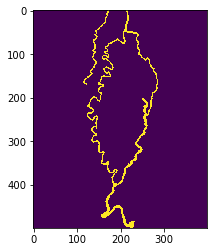

In [5]:
sy = np.s_[6500:7000]
sx = np.s_[7400:7800]

plt.imshow(w[sy, sx])

# Make Products

In [25]:
def generate_rivnet_products(tile_name):
    
    water_mask, ocean_mask, profile = read_masks(tile_name)
    
    transform = profile['transform']
    dx, dy = transform.a, -transform.e
    print('getting distance')
    dist = get_distance_along_river_using_fmm(water_mask,
                                              ocean_mask,
                                              dx=dx,
                                              dy=dy,
                                              # removes areas with less than 2.5% of total size
                                              area_threshold=.025
                                              )


    
    print('getting segments')
    pixel_step = 10
    segments, interface_adj_segments = get_distance_segments(dist,
                                                             pixel_step,
                                                             dx=dx,
                                                             dy=dy)
    print('Generating undirected network')
    rivG_undirected = get_undirected_river_network(segments, 
                                                   dist, 
                                                   profile, 
                                                   interface_adj_segments)
    
    print('directing network')
    rivG = direct_river_network_using_distance(rivG_undirected, 
                                               remove_danlging_segments=True, 
                                               segment_threshold=3,
                                               meters_to_interface_filter_buffer=1_000,
                                               )

    
    print('adding widths')
    width_features = get_width_features_from_segments(segments, profile)
    rivG = add_widths_to_graph(rivG, width_features.ravel())
    
    return dist, segments, rivG, profile

In [13]:
tile_name = tiles[0]

In [14]:
dist, segments, rivG, profile = generate_rivnet_products(tile_name)

getting distance
getting segments
Generating undirected network


adding edges: 100%|██████████| 15078/15078 [00:00<00:00, 194288.60it/s]


directing network
adding widths


In [15]:
# df_edges = export_edges_to_geodataframe(rivG)
# df_edges.plot()

In [18]:
def write_products(dist, segments, rivG, profile, tile_name):
    out_tile = out/tile_name
    out_tile.mkdir(exist_ok=True, parents=True)
    p = profile.copy()
    
    p['dtype'] = 'float32'
    with rasterio.open(out_tile/'distance.tif', 'w', **p) as ds:
        ds.write(dist, 1)
        
    p['dtype'] = 'int32'
    with rasterio.open(out_tile/'segments.tif', 'w', **p) as ds:
        ds.write(segments, 1)
    
    df_edges = export_edges_to_geodataframe(rivG, profile)
    df_nodes = export_nodes_to_geodataframe(rivG, profile)
    
    df_edges.to_file(out_tile/'rivnet_edges.geojson', driver='GeoJSON')
    df_nodes.to_file(out_tile/'rivnet_nodes.geojson', driver='GeoJSON')
    nx.write_gpickle(rivG, out_tile/'river_network.pkl')

In [19]:
write_products(dist, segments, rivG, profile, tile_name)

# Altogether

In [23]:
def get_and_write_products(tile_name):
    dist, segments, rivG, profile = generate_rivnet_products(tile_name)
    print('writing products')
    write_products(dist, segments, rivG, profile, tile_name)


In [26]:
list(map(get_and_write_products, tqdm(tiles)))

  0%|          | 0/3 [00:00<?, ?it/s]

getting distance
getting segments
Generating undirected network



adding edges: 100%|██████████| 15078/15078 [00:00<00:00, 184410.98it/s]

directing network
adding widths
writing products


 33%|███▎      | 1/3 [02:30<05:00, 150.26s/it]

getting distance
getting segments
Generating undirected network



adding edges: 100%|██████████| 11481/11481 [00:00<00:00, 171401.13it/s]

directing network
adding widths
writing products


 67%|██████▋   | 2/3 [04:52<02:27, 148.00s/it]

getting distance
getting segments
Generating undirected network



adding edges: 100%|██████████| 12121/12121 [00:00<00:00, 185836.69it/s]

directing network
adding widths
writing products


100%|██████████| 3/3 [05:56<00:00, 122.76s/it]


[None, None, None]